<center>
<img src="./images/ods_stickers.jpg" />
    
# Introducción al Machine Learning 2020

Basado en material de Pattern Classsification Duda, Hart, Stork. Traducido y editado al español por [Ana Georgina Flesia](https://www.linkedin.com/in/georginaflesia/). Este material esta sujeto a los términos y condiciones de la licencia  [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Se permite el uso irrestricto para todo propósito no comercial.

# IntML2020 - Teoría Bayesiana - Estimación

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy.linalg import inv, det
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.metrics import zero_one_loss
from itertools import combinations
from scipy.stats import expon, norm
from bayessian_classifier import ClasssifierBayesian, ClassifierOneFeature
from matplotlib.colors import ListedColormap
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from scipy.integrate import quad

# Ejercicio 1. 

Utilice el ejemplo de scikit-learn para graficar las regiones de clasificacion lineal y cuadratica para Iris usando conjuntos de dos variables. 

https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py
    


# *Respuesta* 

In [2]:
def plot_decision_regions(ax, X, y, classifier, xy_labels,
                          resolution=0.02):
    
    # setup marker generator and color map
    markers = ('$s$', '$v$', '$V$')
    colors = ('red', 'blue', 'lightgreen')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    labels = ['setosa', 'versicolor', 'virginica']
    
    # train the classifier and get the predictions
    y_predict = classifier.fit(X, y).predict(X)
    # plot the decision surface
    x1_min, x1_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    x2_min, x2_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl].iloc[:, 0],
                   y=X[y == cl].iloc[:, 1],
                   edgecolors=cmap(idx),
                   marker=markers[idx],
                   label=labels[idx])
        ax.set_xlabel(xy_labels[0])
        ax.set_ylabel(xy_labels[1])
    error_rate = round(zero_one_loss(y, y_predict), 3)
    ax.set_title('Error rate: ' + str(error_rate))
    

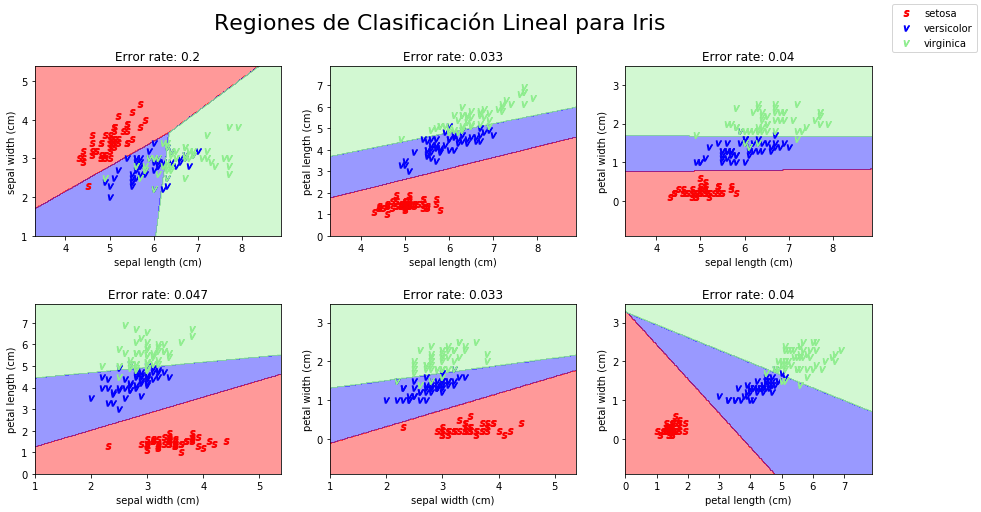

In [3]:
# Obtain the combinations of features of the iris data
iris = load_iris(as_frame=True)
iris_features = iris['feature_names'] 
comb_features = list(map(lambda x: list(x),
                         list(combinations(iris_features, 2))))

# Create the linear classifier 
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
# Create the figure
fig = plt.figure(figsize=(15, 7.5))

num_feat = len(comb_features)
X = iris['data']
y = iris['target']

for comb, idx in zip(comb_features, range(num_feat)):
    ax = fig.add_subplot(2, 3, idx+1)
    plot_decision_regions(ax, X[comb], y, lda, comb)
fig.subplots_adjust(hspace=0.4)
fig.suptitle('Regiones de Clasificación Lineal para Iris', size=22)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels);

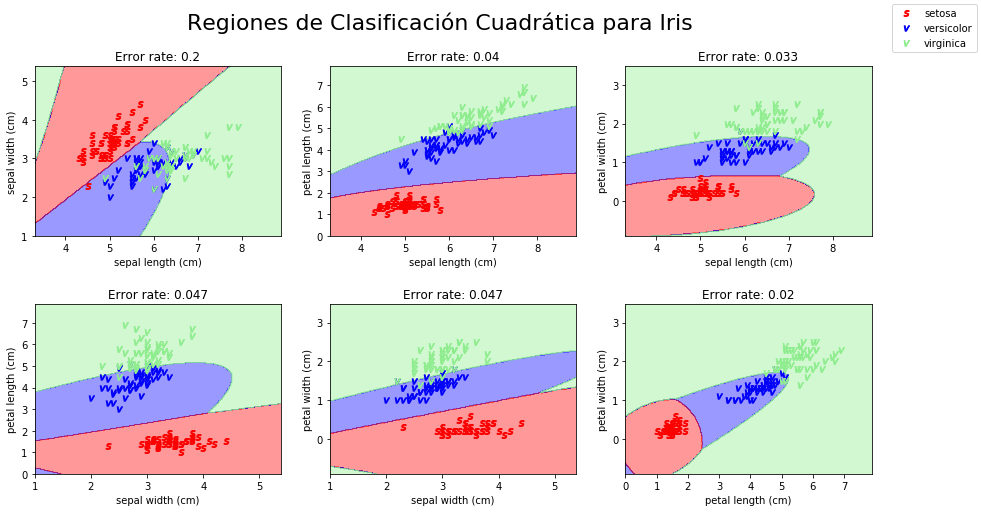

In [4]:
# Create the cuadratic classifier 
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
# Create the figure
fig = plt.figure(figsize=(15, 7.5))

for comb, idx in zip(comb_features, range(num_feat)):
    ax = fig.add_subplot(2, 3, idx+1)
    plot_decision_regions(ax, X[comb], y, qda, comb)
fig.subplots_adjust(hspace=0.4)
fig.suptitle('Regiones de Clasificación Cuadrática para Iris', size=22)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels);

# Ejercicio 2. 

* [a)] Ajuste los discriminantes lineales y cuadraticos sobre Iris con las 3 poblaciones. 

* [b)] Ajuste mezcla de Gaussianas para las tres poblaciones. Use la pagina 

https://scikit-learn.org/stable/modules/mixture.html

https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html

https://www.kaggle.com/danielhanchen/gaussian-mixture-models-on-mnist-iris

https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py


* [c)] Ajuste un clasificador del tipo Naive Bayes Gaussiano. 

https://scikit-learn.org/stable/modules/naive_bayes.html

Use la pagina 
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

para armar comparaciones de todos los clasificadores anteriores. 

Diga como estima los parametros en cada caso. 

* [d]  Explique como utilizaria la curva ROC para realizar comparaciones sobre Iris con todos estos clasificadores. 

# *Respuesta* 

 <span style="color:green"> a) </span>
 
 En el inciso anterior ajustamos clasificadores lineales y cuadráticos para iris.

 <span style="color:green"> b) </span>
 
Para construir un clasificador basado en mezcla de gaussianas. Se deben setear los siguientes parámetros:

* ```n_components```: que especifica el número de componentes en la distribución subyacente. En el caso de iris será el número de distintas especies, osea 3. 

* ```covariance_type```: se debe especificar el tipo de covarianza a usar. En este caso se grafican las clasificaciones con todos los valores posibles.

* ```n_iter```: se refiere al número de iteraciones del algoritmo Expectation-Maximization que se correran durante el entrenamiento.

Luego se inicializaron las **medias** del clasificador por ser un caso de aprendizaje supervisado.

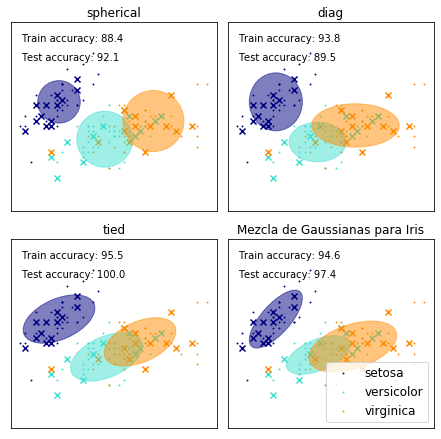

In [5]:
colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = load_iris()
        
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))

X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]
        
n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.title('Mezcla de Gaussianas para Iris');

 <span style="color:green"> c) </span>
 
 Por último Naive Bayes se uso sin inicializar parámetros aunque se toman los valores de default.

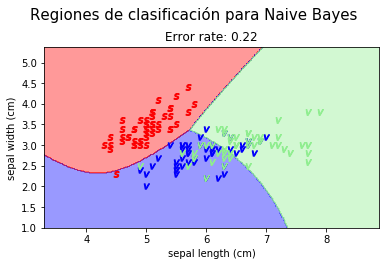

In [6]:
gnb = GaussianNB()
comb_1 = comb_features[0]

fig = plt.figure()
fig.suptitle('Regiones de clasificación para Naive Bayes', fontsize=15)
ax = fig.add_subplot()
plot_decision_regions(ax, X.loc[:, comb_1], y, gnb, comb_1)
fig.tight_layout(pad=3)

Ahora implmentamos el comparador de clasificadores...

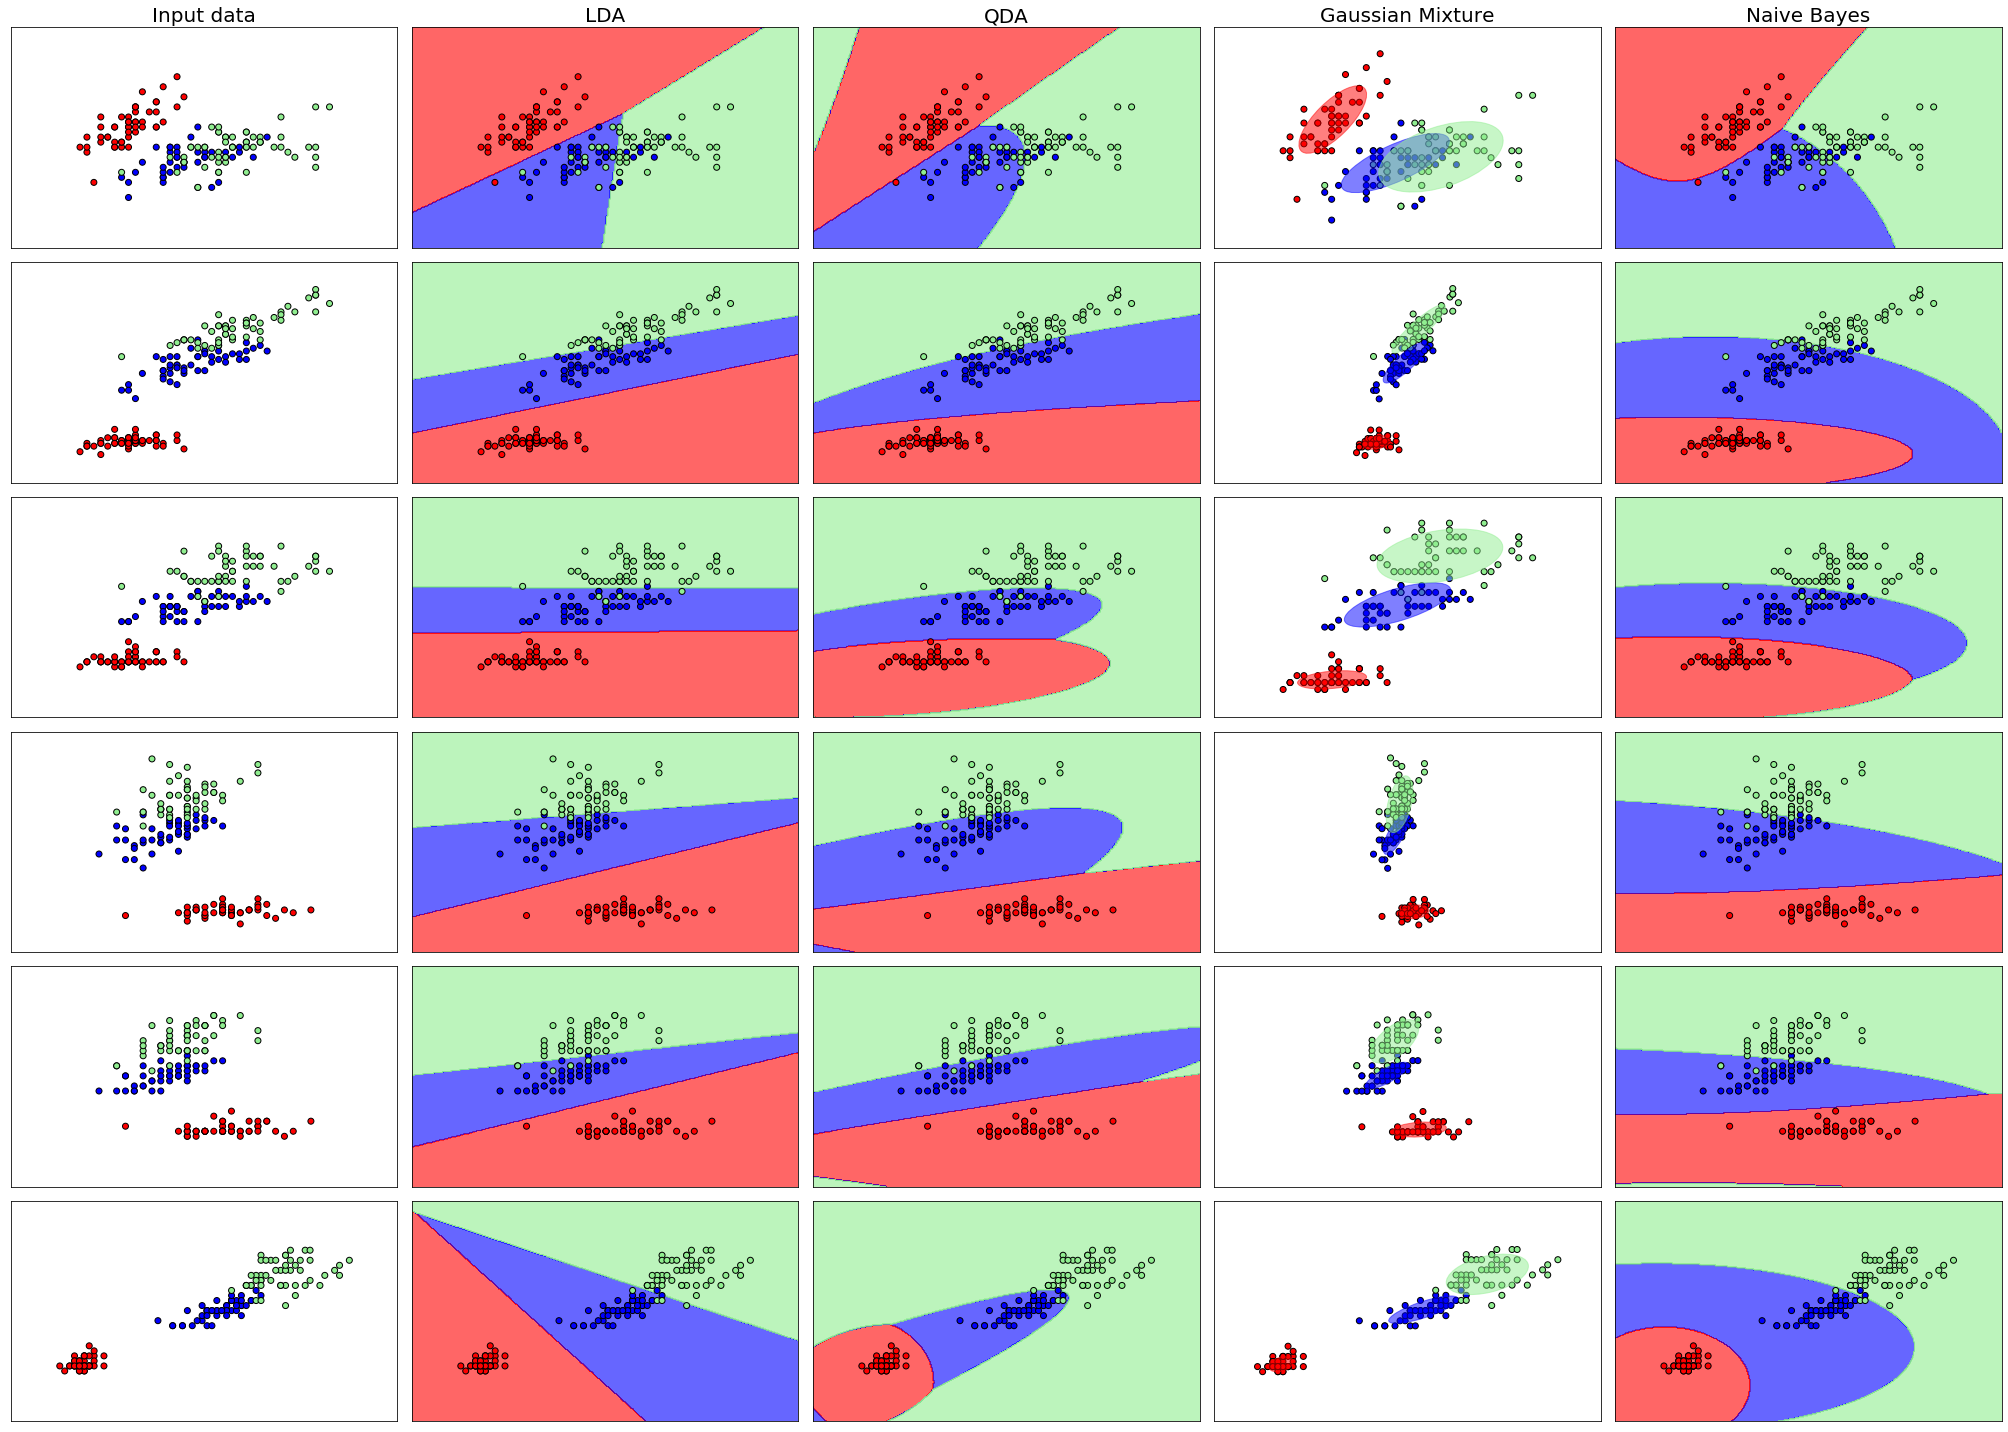

In [7]:
h = .02  # step size in the mesh

names = ["LDA", "QDA", "Gaussian Mixture", "Naive Bayes",]
n_classes = len(np.unique(y))

classifiers = [
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    GaussianMixture(n_components = n_classes),
    GaussianNB(),
    ]


figure = plt.figure(figsize=(28, 20))
i = 1
# iterate over the combinations of iris features.
for comb_cnt, comb in enumerate(comb_features):
#for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X_comb = X[comb]
    x_min, x_max = X_comb.iloc[:, 0].min() - 1 , X_comb.iloc[:, 0].max() + 1
    y_min, y_max = X_comb.iloc[:, 1].min() - 1, X_comb.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # just plot the dataset first
    colors = ['red', 'blue', 'lightgreen']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    ax = plt.subplot(len(comb_features), len(classifiers) + 1, i)
    if comb_cnt == 0:
        ax.set_title("Input data", fontsize=20)
    # Plot the points
    ax.scatter(X_comb.iloc[:, 0], X_comb.iloc[:, 1], c=y, cmap=cmap,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(comb_features), len(classifiers) + 1, i)
        if name == "Gaussian Mixture":
            clf.means_init = np.array([X_comb[y == i].mean(axis=0)
                                    for i in range(n_classes)])
            clf.fit(X_comb, y)
            make_ellipses(clf, ax)
        else:
            clf.fit(X_comb, y)
            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.6)

        # Plot the training points
        ax.scatter(X_comb.iloc[:, 0], X_comb.iloc[:, 1], c=y, cmap=cmap,
                   edgecolors='k')
        
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if comb_cnt == 0:
            ax.set_title(name, fontsize=20)
        i += 1

figure.tight_layout()

 <span style="color:green"> d) </span>
 
Las curva ROC puede ser utilizada en la evaluación del rendimiento de clasificadores. Estas curva relaciona el porcentaje de todos los positivos reales (TP/ (TP+ FN)) en el dataset (eje y) con el ratio de falsos positivos (FP/ (FP + VN)) (eje x). La curva ROC proporciona herramientas para seleccionar los modelos posiblemente óptimos.
Además este método tiene las ventajas de ser invariable con respecto a la escala y con respecto al umbral de clasificación.

El AUC es el área bajo la curva ROC y es una de las formas de interpretarla. Este índice se puede interpretar como la probabilidad de que un clasificador ordenará o puntuará una instancia positiva elegida aleatoriamente más alta que una negativa. Esta área posee un valor comprendido entre 0,5 y 1, donde 1 representa un valor diagnóstico perfecto y 0,5 es una prueba sin capacidad discriminatoria. Es decir, si AUC para una prueba diagnóstica es 0,8 significa que existe un 80% de probabilidad de que el diagnóstico realizado a un enfermo sea más correcto que el de una persona sana escogida al azar. Por esto, siempre se elige la prueba diagnóstica que presente un mayor área bajo la curva.

A modo de guía para interpretar las curvas ROC se han establecido los siguientes intervalos para los valores de AUC:

* [0.5]: Es como lanzar una moneda.

* [0.5, 0.6): Test malo.

* [0.6, 0.75): Test regular.

* [0.75, 0.9): Test bueno.

* [0.9, 0.97): Test muy bueno.

* [0.97, 1): Test excelente.

# Ejercicio 3.

Supongamos que la variable $X$ tiene distribución exponencial

$$
	p(x|\theta)=\left\{
	\begin{array}{lcr}
		 \theta e^{-\theta x} & \ &\mbox{ si }x \geq0 \\
		 \ 0 &\ &\mbox{en caso contrario}\\
	\end{array}
	\right.
$$


* [a)] Grafique $p(x|\theta)$ versus $x$ para $\theta=1$. Grafique $p(x|\theta)$ versus $\theta$, $(0 \leq \theta \leq 5)$, para $x = 2$.

* [b)] Suponga que $n$ ejemplos $x_1 , \cdots , x_n$ se generan independientemente de acuerdo a $p(x|\theta)$. Muestre que el estimador de máxima verosimilitud para $\theta$ está dado por:
$$\hat{\theta}=\frac{1}{\frac{1}{n}\sum_{k=1}^{n}{x_k}}$$

* [c)] En su gráfico generado con $\theta = 1$ en la parte a), marque el estimador de máxima verosimilitud $\hat{\theta}$ para $n$ grandes.



# *Respuesta* 

* (a) 

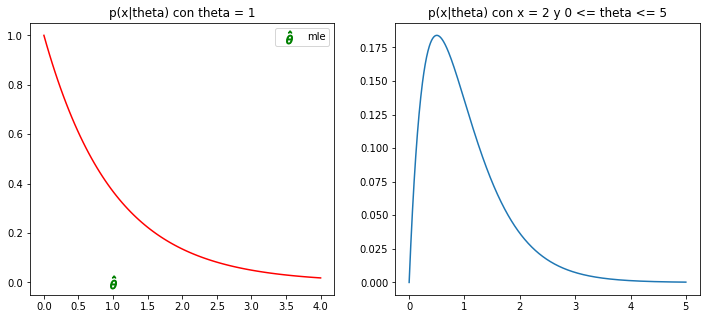

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
x = np.linspace(0, 4, 100)
ax[0].plot(x, expon.pdf(x), 'r')
ax[0].plot(1.0, 0.0, marker=r'$\hat\theta$', 
           markersize=13, color='green',
           label='mle', linestyle='None')
ax[0].set_title('p(x|theta) con theta = 1')
ax[0].legend();

theta = np.linspace(0, 5, 1000)
ax[1].plot(theta, theta*np.exp(-2*theta))
ax[1].set_title('p(x|theta) con x = 2 y 0 <= theta <= 5');

* (b)

Tenemos que la función de verosimilitud de $\theta$ con respecto a la muestra ${x_1 , \cdots , x_n}$ esta por:

$$p(\{x_1 , \cdots , x_n \}| \theta) = \prod_{k=1}^n p(x_k|\theta)$$ Luego el estimador de máxima verosimilitud de $\theta$ es el valor $\hat{\theta}$ que maximiza la función de máxima verosimilitud. 

Para encontrar ese valor, definimos el logaritmo de la verosimilitud:

$$l(\theta) = \ln p(\{x_1 , \cdots , x_n \}| \theta) = \sum_{k=1}^n \ln p(x_k|\theta) = \sum_{k=1}^n \ln \theta e^{-\theta x_k} = \sum_{k=1}^n \ln \theta - x_k \theta = n \ln \theta - \sum_{k=1}^n x_k \theta$$

Para encontrar el máximo $\hat{\theta}$ de $l(\theta)$ debemos hallar el valor de $\theta$ que cumpla $\nabla_\theta l = 0$ donde $\nabla_\theta = \left[\dfrac{\partial}{\partial \theta}\right]$. 

Entonces:

$$\nabla_\theta l = \dfrac{n}{\theta} - \sum_{k=1}^n x_k = 0 \iff  \dfrac{n}{\theta} = \sum_{k=1}^n x_k \iff \theta = \frac{1}{\dfrac{1}{n}\sum_{k=1}^n x_k}$$ Por lo tanto el estimador $\hat{\theta} = \dfrac{1}{\frac{1}{n}\sum_{k=1}^n x_k}$

* (c)

Para $n$ grande, el promedio ${\frac{1}{n}\sum_{k=1}^n x_k}$ converge a la esperanza de la distribución que en este caso es $1$ (pues $\frac 1 \theta = 1$ con $\theta = 1$). Por lo tanto, $\hat{\theta} = 1$

# Ejercicio 4. 

Supongamos que la variable $X$ tiene distribución uniforme

$$
	p(x|\theta)\thicksim U(0,\theta)=\left\{
	\begin{array}{lcr}
		 {1}/{\theta} 	& \ 		&\mbox{ si }0 \leq x \leq \theta \\
		 \ 0 &\ &\mbox{en caso contrario}\\
	\end{array}
	\right.
$$

* [a)] Suponga que $n$ ejemplos $ D = \{ x_1,\ldots,x_n \} $ son generados independientemente de acuerdo a $p(x|\theta)$. Muestre que el estimador de máxima verosimilitud para $\theta$ es $max[D]$, esto es el valor del máximo elemento de $D$.
* [b)] Suponga que son generados $n=5$ puntos acorde con esta distribución y el maximo valor de esos puntos es  ${\max}_k (x_k)=0.6$. Grafique la verosimilitud $p(D|\theta)$ en el rango $0 \leq \theta \leq 1$. Explique con palabras por que no es necesario conocer los otros 4 puntos.



# *Respuesta* 

 <span style="color:green"> a) </span>
 
 La función de máxima verosimilitud en este caso es:
  
 $$p(x|D) = \prod_{k=1}^n p(x_k|\theta) = \prod_{k=1}^n \dfrac 1 \theta \mathbb 1(0 \le x_k \le \theta) = \dfrac{1}{\theta^n} \mathbb 1(\max\limits_{k} x_k \le \theta \land \min\limits_{k} x_k \ge 0)$$
 
 Como $\dfrac{1}{\theta^n}$ es decreciente a medida que $\theta$ se incrementa, luego es máxima para el valor más pequeño de $\theta$. Luego el $\hat\theta = \max\limits_{k} x_k$

 <span style="color:green"> b) </span>
 
 Usando Bayes recursivo para estimar $\theta$, en cada paso se introduce un factor $\dfrac 1 \theta$ en $p(x|\theta)$ y un nuevo valor acota a $\theta$ por debajo. Luego , como la distribución es no cero sólo para valores $x$ por encima del máximo valor muestreado, entonces no es necesario conocer los otros valores y obtenemos que $0.6 \le \theta \le 1$.

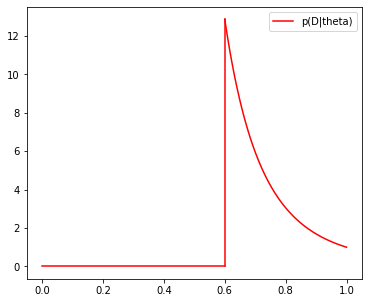

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
x = np.linspace(0, 0.6, 100)
ax.plot(x,np.zeros(100), 'r')
ax.plot((0.6, 0.6), (0, 1/(0.6)**5), 'r')
theta = np.linspace(0.6, 1, 100)
ax.plot(theta, 1/(theta**5), 'r', label='p(D|theta)')
ax.legend();

# Ejercicio 5


Considere los modelos de clasificación con densidad Gaussiana en diferentes dimensiones:

* [a)] Escriba un programa para encontrar los valores de maxima verosimilitud $\hat\mu$ y $\hat\sigma^2$. Aplique su programa individualmente para cada una de las tres caracteristica $x_i$ de la categoria $w_1$ de la Tabla que se levanta como datos.data.

* [b)] Modifique su programa para aplicarlo a datos Gaussianos bidimensionales $p(x)\sim N(\mu,\Sigma)$. Aplique su programa para cadas una de las tres formas de apareamiento de a dos caracteristicas para $w_1$.
* [c)] Modifique su programa para aplicarlo a datos Gaussianos de tres dimensiones. Aplique su programa para a las tres dimensiones de la categoria $w_1$.
* [d)] Asuma que su modelo de tres dimensiones es separable, por lo tanto $\Sigma=diag(\sigma_1^2,\sigma_2^2,\sigma_3^2)$. Escriba un programa para estimar la media y los componentes diagonales de $\Sigma$. Aplique el programa a los datos en $w_2$.
* [e)] Compare los resultados para la media de cada caracteristica $\mu_i$ calculada en las formas previas. Explique por que son iguales o diferentes.
* [f)] Compare sus resultados para la varianza de cada caracteristica $\sigma_i^2$ calculada de las formas previas. Explique por que los resultados son iguales o diferentes.


In [10]:
data = pd.read_csv('datos.csv')
data.head(5)

,w1_x1,w1_x2,w1_x3,w2_x1,w2_x2,w2_x3,w3_x1,w3_x2,w3_x3
0,0.42,-0.087,0.58,-0.40,0.580,0.089,0.830,1.60,-0.014
1,-0.20,-3.300,-3.40,-0.31,0.270,-0.040,1.100,1.60,0.480
2,1.30,-0.320,1.70,0.38,0.055,-0.035,-0.440,-0.41,0.320
3,0.39,0.710,0.23,-0.15,0.530,0.011,0.047,-0.45,1.400
4,-1.60,-5.300,-0.15,-0.35,0.470,0.034,0.280,0.35,3.100


# *Respuesta* 

 <span style="color:green"> a) </span> 
 
 La máxima verosimilitud para el caso gaussiano de una dimensión se corresponde con:
 
 * La media muestral $(\bar X)$ para $\hat \mu$
 * La varianza muestral $(S_{n-1})$ para $\hat \sigma^2$

In [11]:
def mle_mu(sample):
    return np.mean(sample)

def mle_var(sample):
    return np.var(sample, ddof=1)

In [12]:
columns = ['w1_x1','w1_x2', 'w1_x3']
w1_data = data.loc[:, columns]
means = mle_mu(w1_data)
print('Las medias estimadas:')
print(means.to_string())

Las medias estimadas:
w1_x1   -0.0709
w1_x2   -0.6047
w1_x3   -0.9110


In [13]:
vars_ = mle_var(w1_data)
print('Las varianzas estimadas:')
print(vars_.to_string())

Las varianzas estimadas:
w1_x1    1.006864
w1_x2    4.667461
w1_x3    5.046610


 <span style="color:green"> b) </span>
 
 En el caso multinormal, los estimadores de máxima verosimilitud son:
 
 * $ \dfrac 1 n \displaystyle \sum_{k=1}^n \boldsymbol x_k$ para el caso de $\boldsymbol{\hat{\mu}}$
 
 * $\dfrac{1}{n-1} \displaystyle \sum_{k=1}^n (\boldsymbol x_k - \boldsymbol{\hat{\mu}})(\boldsymbol x_k - \boldsymbol{\hat{\mu}})^T$ para el caso de $\hat{\Sigma}$

El programa para estimar medias del inciso anterior funciona para dos dimensiones. Para el caso de sigma tenemos que estimar la matriz de covarianza de la muestra. 

In [14]:
def mle_sigma(samples):
    return np.cov(samples, rowvar=False, ddof=1)

In [15]:
w1_comb = list(map(lambda x: list(x),
                   list(combinations(columns, 2))))

for comb in w1_comb:
    means = mle_mu(data.loc[:, comb])
    print('Las medias estimadas para:', comb)
    print('\t * '+ str(means.to_string().split('\n')) + '\n')

Las medias estimadas para: ['w1_x1', 'w1_x2']
	 * ['w1_x1   -0.0709', 'w1_x2   -0.6047']

Las medias estimadas para: ['w1_x1', 'w1_x3']
	 * ['w1_x1   -0.0709', 'w1_x3   -0.9110']

Las medias estimadas para: ['w1_x2', 'w1_x3']
	 * ['w1_x2   -0.6047', 'w1_x3   -0.9110']



In [16]:
w1_comb = list(map(lambda x: list(x),
                   list(combinations(columns, 2))))

for comb in w1_comb:
    sigma = mle_sigma(data.loc[:, comb])
    print('Las sigma estimadas para:', comb)
    print()
    print(str(sigma) + '\n')

Las sigma estimadas para: ['w1_x1', 'w1_x2']

[[1.00686366 0.63086863]
 [0.63086863 4.6674609 ]]

Las sigma estimadas para: ['w1_x1', 'w1_x3']

[[1.00686366 0.43786678]
 [0.43786678 5.04661   ]]

Las sigma estimadas para: ['w1_x2', 'w1_x3']

[[4.6674609  0.81522478]
 [0.81522478 5.04661   ]]



 <span style="color:green"> c) </span> 
 
 Los programas que hicimos pueden aplicarse perfectamente al caso de tres dimensiones. En el caso de la media muestral para tres dimensiones es lo mismo salvo que ahora tenemos un vector $3 \times 1$ como resultado. Y la matriz de covarianzas tiene dimensión $3 \times 3$.

In [17]:
means = mle_mu(w1_data)
print('El vector de medias estimadas es:')
print(means.to_string().split('\n'))

El vector de medias estimadas es:
['w1_x1   -0.0709', 'w1_x2   -0.6047', 'w1_x3   -0.9110']


In [18]:
sigma_3 = mle_sigma(w1_data)
print('La sigma estimada es: \n')
print(sigma_3)

La sigma estimada es: 

[[1.00686366 0.63086863 0.43786678]
 [0.63086863 4.6674609  0.81522478]
 [0.43786678 0.81522478 5.04661   ]]


 <span style="color:green"> d) </span>
 
 Si $\Sigma=diag(\sigma_1^2,\sigma_2^2,\sigma_3^2)$ entonces $\sigma_{ij} = 0$ para $i \ne j$. Por lo tanto sólo debemos calcular las varianzas de cada columna individualmente y no las $\sigma_i^2\sigma_j^2$ para $i \ne j$. Para calcular las medias pueden usarse el mismo programa del primer inciso.

In [19]:
def mle_sigma_dig(samples):
    vars_ = np.array([np.var(samples, ddof=1)])
    sigma = np.eye(3)
    return vars_ * sigma

In [20]:
colums_2 = ['w2_x1','w2_x2', 'w2_x3']
w2_data = data.loc[:, colums_2]

means = mle_mu(w2_data)
print('El vector de medias estimadas es:')
print(means.to_string())

El vector de medias estimadas es:
w2_x1   -0.11260
w2_x2    0.42990
w2_x3    0.00372


In [21]:
sigma_dig = mle_sigma_dig(w2_data)
print('La sigma estimada es: \n')
print(sigma_dig)

La sigma estimada es: 

[[0.0599176  0.         0.        ]
 [0.         0.05107788 0.        ]
 [0.         0.         0.00807278]]


 <span style="color:green"> e) </span>
 
 Las medias se calculan de igual forma en la caso unidimensional como multidimensional, por lo tanto el mismo método pudo aplicarse en todos los casos y se obsevan los mismos resultados.
 
  Para cada categoria $\mu_i$ se calcula mirando los datos dentro de la misma caracteristica $($es decir, $x_1, x_2, x_3$, las columnas$)$. Si estamos en el caso multinormal de $d$ dimensiones entonces $\boldsymbol{\hat \mu} = (\mu_1,..., \mu_d)$ donde cada $\mu_i$ es la media de su columna.

 <span style="color:green"> d) </span>
 
 Tambien observamos que las varianzas $\sigma_i^2$ se repiten en el caso unidimensional como multidimimensional y corresponden a la varianza muestral dentro de una misma característica (columnas). En el caso multidimensional se ubican en la diagonal de la matriz de covarianza. 

# Ejercicio 6 

Considere la estimación Bayesiana de la media de una distribucion Gaussiana unidimensional. Suponga una distribución a priori $p(\mu)\sim N(\mu_0,\sigma_0)$

* [a)] Calcule con todos los pasos $p(\mu|D)$ y $p(x|D)$ en el caso Gaussiano unidimensional donde $\mu$ es desconocida, determinando cual es la densidad reproductora y cual es el prior conjugado. Diga cual es el dogmatismo, es decir, el balance entre el conocimiento previo y el conocimiento emprírico proveniente de los datos. Obtenga esta información del libro. Tiene a su disposición una versión .djvu completa y pdf del capitulo 3. 

* [b)] Escriba un programa que dibuje la densidad $p(x|D)$ dado $\mu_0, \sigma_0,\sigma$ y la muestra de entrenamiento $D=\{x_1,\cdots, x_n\}$, 

* [c)] Estime $\sigma$ para la componente $x_2$ de la muestra $\omega_3$ de la tabla anterior. Suponga que $\mu_0=-1$, grafique $p(x|D)$ para cada uno de los siguientes dogmatismos $\sigma^2/\sigma_0^2= 0.1,1,10,100$. 

 # *Respuesta*   <font color = 'RED'> estudiar esta respuesta </font>


* [a)] Consideramos la estimación bayesiana de la media de una distribución Gaussiana unidimensional, donde la distribución a priori de esta media es también gaussiana: $p(\mu) \sim N(\mu_0, \sigma_0)$.

Dada una muestra $\mathcal D = \{x_1, x_2, \dots, x_n\}$, tenemos entonces que
$$p(x_i | \mu) = \frac 1{\sqrt{2\pi}\sigma} e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}, \qquad \sigma \mbox{ conocida}.$$

La estimación a posteriori de $\mu$ dada la muestra $\mathcal D$ está dada por 
$$p(\mu|\mathcal D) = \frac{p(\mathcal D | \mu) p(\mu)} { \int p(\mathcal D | \mu)p(\mu) d\mu}.$$

Denotamos $\alpha = p(\mathcal D)^{-1}$, esto es:
$$\alpha = \frac 1{ \int p(\mathcal D | \mu)p(\mu) d\mu}.$$
Por otra parte, como la muestra $\mathcal D$ es de observaciones independientes su probabilidad es el producto de las probabilidades individuales. Así resulta:
$$p(\mu|\mathcal D) =\alpha \, p(\mathcal D | \mu) p(\mu) = \alpha \left( \prod_{i=1}^n p(x_i | \mu)\right) \cdot p(\mu).$$

Luego,
\begin{eqnarray}
p(\mu|\mathcal D)  &=& \alpha \left(  \prod_{i=1}^n \frac 1{\sqrt{2\pi}\sigma} e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}
\right)\, \frac 1{\sqrt{2\pi}\sigma_0} e^{-\frac{(\mu-\mu_0)^2}{2\sigma_0^2}} = \frac{\alpha}{(2\pi)^{(n+1)/2}\sigma\sigma_0} \left(  \prod_{i=1}^n e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}
\right)\, e^{-\frac{(\mu-\mu_0)^2}{2\sigma_0^2}}
\end{eqnarray}
Sumamos los exponentes en las $(n+1)$ exponenciales y resulta:

\begin{eqnarray}
-\left(\sum_{i=1}^n \frac{(x_i-\mu)^2}{2\sigma^2} \right)-\frac{(\mu-\mu_0)^2}{2\sigma_0^2} &=& -\frac 12
\left(\sum_{i=1}^n \frac{(x_i-\mu)^2}{\sigma^2} \right)+\frac{(\mu-\mu_0)^2}{\sigma_0^2}  
\\
&=&
-\frac 12 \left( \sum_{i=1}^n \frac {x_i^2}{\sigma^2} - 2 \sum_{i=1}^n \frac{x_i \mu}{\sigma^2} + n \frac{\mu^2}{\sigma^2} + \frac{\mu^2}{\sigma_0^2} - 2\frac{\mu_0\mu}{\sigma_0^2} + \frac{\mu_0^2}{\sigma_0^2}\right)
\\
&=&
-\frac 12 \left( \sum_{i=1}^n \frac {x_i^2}{\sigma^2} + \frac{\mu_0^2}{\sigma_0^2}\right) - \frac 12 
\left( \left( \frac n{\sigma^2} + \frac 1{\sigma_0^2} \right) \mu^2 - 2 \left(   \sum_{i=1}^n \frac{x_i \mu}{\sigma^2} + \frac{\mu_0}{\sigma_0^2}\right) \mu \right) \\
&=&
A + B + C
\end{eqnarray}
El término $A$ no depende de $\mu$ por lo que $e^A$ lo agrupamos con $\alpha$.

Los términos $B$ y $C$ pueden completarse para formar el cuadrado de un binomio:
$$ \left( \frac n{\sigma^2} + \frac 1{\sigma_0^2} \right) \mu^2 - 2 \left(   \sum_{i=1}^n \frac{x_i}{\sigma^2} + \frac{\mu_0}{\sigma_0^2}\right) \mu  = 
a \mu^2 - 2b \mu = a \left( \mu^2 -2\frac ba \mu + \left(\frac ba\right)^2 -  \left(\frac ba\right)^2\right) 
= \frac{ (\mu - \frac ba)^2}{1/a} - \frac{b^2}a
$$
donde
$$a = \frac n{\sigma^2} + \frac 1{\sigma_0^2}, \qquad b =  \sum_{i=1}^n \frac{x_i}{\sigma^2} + \frac{\mu_0}{\sigma_0^2} = \frac n{\sigma^2} \,\overline x  + \frac{\mu_0}{\sigma_0^2}. \qquad \overline x = \frac 1n \sum_{i=1}^n x_i.$$

Así resulta que la densidad reproductura $p(\mu|\mathcal D)$ es una densidad normal con media:
$$\mu_n = \frac ba = \frac {\frac n{\sigma^2} \,\overline {x_n}  + \frac{\mu_0}{\sigma_0^2}}{\frac n{\sigma^2} + \frac 1{\sigma_0^2}} = \frac{n \overline {x_n} \sigma_0^2 + \mu_0\sigma^2}{n\sigma_0^2 + \sigma^2}$$
 y varianza
 $$ \sigma_n^2 = \frac 1 a = \frac{\sigma^2 \sigma_0^2}{n\sigma_0^2 + \sigma^2},$$
 siendo $\overline{x_n}$ la media muestral de los $n$ datos observados.
 
 ### Cálculo de $p(x|\mathcal D)$
 
\begin{eqnarray}
p(x | \mathcal D) &=& \int p(x |\mu)p(\mu|\mathcal D) d\mu \\
&=&\int \frac 1{\sqrt{2\pi}\sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}}\,\frac 1{\sqrt{2\pi}\sigma_n} e^{-\frac{(\mu-\mu_n)^2}{2\sigma_n^2}}\,d\mu \\
&=&
{}\frac 1{2\pi\sigma\sigma_n}\int \exp\left(
-\frac{(x-\mu)^2}{2\sigma^2}-\frac{(\mu-\mu_n)^2}{2\sigma_n^2}\right)\, d\mu \\
&=&
{}\frac 1{2\pi\sigma\sigma_n}\int \exp\left(
-\frac{\sigma_n^2(x^2-2\mu x + \mu^2)}{2\sigma^2\sigma_n^2}
-\frac{\sigma^2(\mu^2-2\mu\mu_n+\mu_n^2)}{2\sigma_n^2\sigma^2}\right)\, d\mu \\
&=&
{}\frac 1{2\pi\sigma\sigma_n}\int \exp\left(
-\frac{(\sigma_n^2+ \sigma^2)\mu^2 - 2\mu (x\sigma_n^2  +\sigma^2\mu_n) + \sigma_n^2x^2 + \sigma^2\mu_n^2}{2\sigma_n^2\sigma^2}\right)\, d\mu \\
&=&
\frac 1{2\pi\sigma\sigma_n}
\int \exp\left(- \frac{(\mu - \frac{x\sigma_n^2  +\sigma^2\mu_n}{\sigma_n^2 + \sigma^2})^2}{\frac{2\sigma_n^2\sigma^2}{\sigma_n^2 + \sigma^2}} \right)d\mu \exp\left(
\frac{x^2 \sigma^2 + \sigma_n^2\mu_n^2 - \frac{(x\sigma^2 + \mu_n\sigma_n^2)^2}{\sigma^2 + \sigma_n^2}}{\sigma^2\sigma_n^2}
\right)
\end{eqnarray}

La integral respecto de $\mu$ es proporcional a la integral de la densidad de una normal, con media y desvío estándar dado por:
$$\mu_1 = \frac{x\sigma_n^2  +\sigma^2\mu_n}{\sigma_n^2 + \sigma^2} \qquad 
\sigma_1 =\frac{2\sigma_n^2\sigma^2}{\sigma_n^2 + \sigma^2}. $$
Por lo tanto es igual a $\sqrt{2\pi}\sigma_1$, que es independiente del valor de $x$:

Resolvemos el otro factor observando que:
\begin{eqnarray}
x^2 \sigma^2 + \sigma_n^2\mu_n^2 - \frac{(x\sigma^2 + \mu_n\sigma_n^2)^2}{\sigma^2 + \sigma_n^2}
&=& \frac{1}{\sigma^2 + \sigma_n^2} \left( x^2 \sigma^4 + x^2 \sigma^2 \sigma_n^2 + \sigma^2 \sigma_n^2 \mu_n^2 + \sigma_n ^4 \mu_n ^2 - x^2\sigma^4 - \mu_n^2 \sigma_n^4 - 2x\sigma^2 \mu_n \sigma_n^2\right)\\
&=&
\frac{\sigma^2 \sigma_n^2}{\sigma^2 + \sigma_n^2} \left(x^2 - 2x \mu_n + \mu_n^2\right) = \frac{\sigma^2 \sigma_n^2}{\sigma^2 + \sigma_n^2}(x-\mu_n)^2.
\end{eqnarray}

Juntando resultados concluimos que $p(x|\mathcal D)$ tiene distribución normal con media y desvío estándar dados por:
$$\mu_x = \mu_n, \qquad \sigma^2_x = \sigma^2 + \sigma_n^2$$
 
 ### Dogmatismo
 $$\frac{\sigma^2}{\sigma_0^2}$$

 <span style="color:green"> b) </span>
 
 Por el téorico sabemos que $p(x|\mathcal D)$ tiene distribución normal con media y desvío estándar dados por:
$$\mu_x = \mu_n, \qquad \sigma^2_x = \sigma^2 + \sigma_n^2$$
 
A su vez $$\mu_n = \frac{n \overline {x_n} \sigma_0^2 + \mu_0\sigma^2}{n\sigma_0^2 + \sigma^2}\qquad \sigma_n^2 = \frac{\sigma^2 \sigma_0^2}{n\sigma_0^2 + \sigma^2}$$

In [22]:
def plot_pxD(ax, mu_0, sigma_0, sigma, samples):
    mean = np.mean(samples)
    n = samples.shape[0]
    den = n*sigma_0**2 + sigma**2
    mu_n = (n*mean*(sigma_0**2) + (mu_0*sigma**2))/den
    sigma_n = ((sigma**2)*(sigma_0**2))/den
    sigma_x = sigma**2 + sigma_n
    x = np.linspace(-4, 4, 1000)
    ax.plot(x, norm.pdf(x, loc=mu_n, scale=np.sqrt(sigma_x)),
            'b-', alpha=0.6, label='p(x|D)')
    ax.legend()
    ax.set_title('p(x|D) con mu_0 = ' + str(mu_0) + 
                 ', std = ' + str(round(sigma, 3)) + 
                 ' y std_0 = ' + str(round(sigma_0, 3)))

 <span style="color:green"> c) </span>

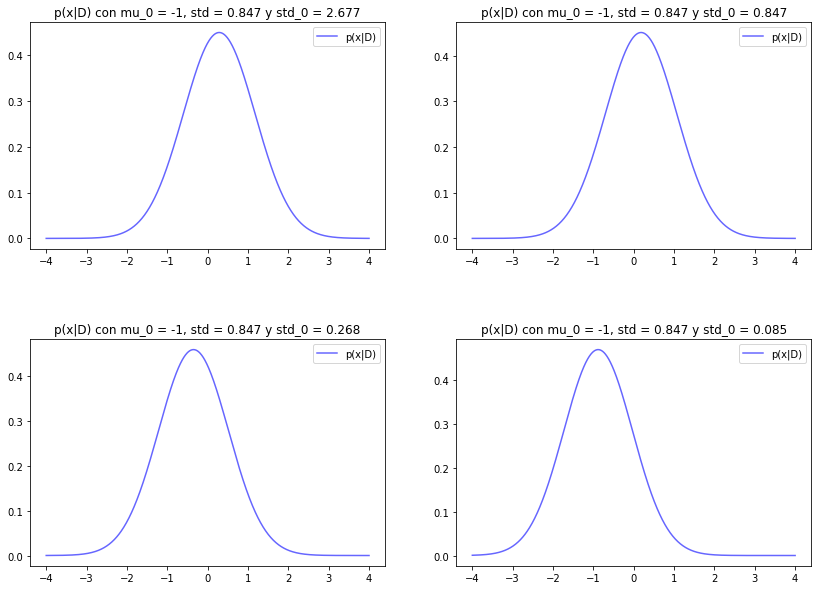

In [23]:
# Estimamos sigma para x2
data_w3_x2 = data.loc[:, 'w3_x2']
std_x2 = np.std(data_w3_x2, ddof=1)
mu_0 = -1
dogmats = [0.1, 1, 10, 100]

stds_0 = list(map(lambda x: std_x2/np.sqrt(x), dogmats))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for std, ax in zip(stds_0, enumerate(fig.axes)):
    plot_pxD(ax[1], mu_0, std, std_x2, data_w3_x2)
fig.subplots_adjust(hspace=0.4)

# Ejercicio 7

Considerar las tasas de error en diferentes dimensiones

* [a)] Use maxima verosimilitud para entrenar un dicotomizador Gaussiano usando los datos tridimensionales de las categorias $w_1$ y $w_2$ en la Tabla. Integre numéricamente para estimar la proporcion del error.
* [b)] Ahora considere los datos proyectados en un subespacio bidimensional. Para cada uno de los tres subespacios - definidos por $x_1=0$, $x_2=0$ o $x_3=0$- entrene un dicotomizador Gaussiano. Integre numericamente para estimar la proporcion del error.
* [c)] Ahora considere los datos proyectados en subespacios unidimensionales, definidos por cada uno de los tres ejes. Entrene un clasificador Gaussiano e integre numericamente para estimar la proporcion del error.
* [d)] Discuta el orden del rango de las tasas de error encontrado.
* [e)] Asumiendo que reestima la distribucion en las diferentes dimensiones, es el error de Bayes  mayor en los espacios proyectados?


# *Respuesta* 

 <span style="color:green"> a) </span>
 
 Primero usamos las funciones de máxima verosimilutud para estimar las medias y las matrices de covarianzas.

In [24]:
mu_1 = mle_mu(w1_data).to_numpy()
mu_2 = mle_mu(w2_data).to_numpy()

sigma_1 = mle_sigma(w1_data)
sigma_2 = mle_sigma(w2_data)

mus = np.array([mu_1, mu_2])
sigmas = np.array([sigma_1, sigma_2])

print('Las medias estimadas:')
print('* mu_1:', mu_1)
print('* mu_2:', mu_2)

print()
print('Las matrices covarianzas estimadas:')
print('* sigma_1:\n', sigma_1)
print('* sigma_2:\n', sigma_2)


Las medias estimadas:
* mu_1: [-0.0709 -0.6047 -0.911 ]
* mu_2: [-0.1126   0.4299   0.00372]

Las matrices covarianzas estimadas:
* sigma_1:
 [[1.00686366 0.63086863 0.43786678]
 [0.63086863 4.6674609  0.81522478]
 [0.43786678 0.81522478 5.04661   ]]
* sigma_2:
 [[ 0.0599176  -0.01627918 -0.00575548]
 [-0.01627918  0.05107788  0.00945541]
 [-0.00575548  0.00945541  0.00807278]]


In [25]:
# Con los valores calculados entrenar el clasificador:
# Asume iguales probabilidades a priori. 
classifier = ClasssifierBayesian(mus, sigmas, [0.5, 0.5])

Recordemos que el error estaba dado por:

$$P(error) = P(x \in \Re_2, \omega_1) +  P(x \in \Re_1, \omega_2)$$

$$= P(x \in \Re_2|\omega_1)P(\omega_1) +  P(x \in \Re_1|\omega_2)P(\omega_2)$$

$$= \int_{\Re_2} p(x|\omega_1)P(\omega_1) +  \int_{\Re_1} p(x|\omega_2)P(\omega_2)$$

El límite de decisión entre las regiones $\Re_1$ y $\Re_2$ se obtiene al hacer que los discriminantes se igualen. Es decir, 

$$g_1(x) = g_2(x) \iff x^TW_1x + w_1^Tx + w_{10}  = x^TW_2x + w_2^Tx + w_{20}$$

$$\iff x^TW_1x + w_1^Tx + w_{10} - x^TW_2x + w_2^Tx + w_{20} = 0 $$

$$\iff x^T(W_1-W_2)x + (w_1-w_2)^Tx + w_{10} - w_{20} = 0 \quad(*)$$

donde $W_i = -\dfrac 12\Sigma_i^-1$, 

$w_i = \Sigma_i^-1\mu_i$ y 

$w_{i0} = -\dfrac 12 \mu_i^T\Sigma_i^-1\mu_i- \dfrac 12 \ln|\Sigma_i| +\ln P(\omega_i)$ 

Esta ecuacion (*) define la fórmula de una superficie cuádrica de la forma:

$Ax^2 + By^2 + Cz^2 + Dxy + Eyz + Fxz + Gx + Hy + Iz + J = 0$

Notamos que al los términos cuadráticos provienen del sumando $x^T(W_1-W_2)x$ y que los coefiecientes $A$, $B$ y $C$ son las diferencias de las varianzas entre cada muestra $\sigma_1^2$, $\sigma_3^2$ y $\sigma_3^2$, respectivamente. 
Luego $D = 2\sigma_1\sigma_2$, $E = 2\sigma_1\sigma_3$ y $F = 2\sigma_2\sigma_3$ y $G$, $H$ y $I$ se obtienen de $w_1 - w_2$.Por otra parte el término $J$ es la constante $w_{10} - w_{20}$.

In [26]:
W1 = (-0.5)*inv(sigma_1)
W2 = (-0.5)*inv(sigma_2)

w10 = -0.5*(mu_1.dot(inv(sigma_1)).dot(mu_1.T)) - 0.5*np.log(det(sigma_1))
w20 = -0.5*(mu_2.dot(inv(sigma_2)).dot(mu_2.T)) - 0.5*np.log(det(sigma_2))

diff = W1 - W2
A = diff[0, 0]
B = diff[1, 1]
C = diff[2, 2]
D = 2*diff[1, 0]
E = 2*diff[2, 0]
F = 2*diff[2, 1]

w1 = inv(sigma_1).T.dot(mu_1)
w2 = inv(sigma_1).T.dot(mu_2)
diff_w = w1-w2
G = round(diff_w[0], 0)
H = round(diff_w[1], 0)
I = round(diff_w[2], 0)

print('Los coeficientes son:')
print('* Coef A:', round(A))
print('* Coef B:', round(B))
print('* Coef C:', round(C))
print('* Coef D:', round(D))
print('* Coef E:', round(E))
print('* Coef F:', round(F))
print('* Coef G:', round(G))
print('* Coef H:', round(H))
print('* Coef I:', round(I))
print('* Coef J:', round(w10 - w20))

Los coeficientes son:
* Coef A: 9.0
* Coef B: 13.0
* Coef C: 81.0
* Coef D: 5.0
* Coef E: 8.0
* Coef F: -27.0
* Coef G: 0.0
* Coef H: -0.0
* Coef I: -0.0
* Coef J: -5.0


Por lo tanto, el limite para $\Re_1$ y $\Re_2$ es el volumen $V = \{(x, y, z) \in \mathbb{R}^3: 9x^2 +13y^2 + 81z^2 + 5xy + 8xz - 27yz = 5\}$

Y definimos: 

$$V_1 = \{(x, y, z) \in \mathbb{R}^3: 9x^2 +13y^2 + 81z^2 + 5xy + 8xz - 27yz > 5\}$$
$$V_2 = \{(x, y, z) \in \mathbb{R}^3: 9x^2 +13y^2 + 81z^2 + 5xy + 8xz - 27yz <= 5\}$$

Por lo que el error:

$$P(error) = \int_{V_1} p(\boldsymbol{x}|\omega_1)P(\omega_1) d\boldsymbol{x} +  \int_{V_2} p(\boldsymbol{x}|\omega_2)P(\omega_2) d\boldsymbol{x} = \dfrac 1 2 \left[\int_{V_1} p(\boldsymbol{x}|\omega_1)d\boldsymbol{x} + \int_{V_2} p(\boldsymbol{x}|\omega_2)d\boldsymbol{x}\right]$$

**Incompleto**

 <span style="color:green"> b) </span>
 
 Ahora se trabaja con dos dimensiones. Se calculan los parametros para cada conjunto de datos y luego se entrena un clasificador. Luego para calcular el error se integran sobre las regiones.

In [27]:
# Obtenemos los datos bidimensionales
data1_x1_zero = w1_data.iloc[:, [1, 2]]
data1_x2_zero = w1_data.iloc[:, [0, 2]]
data1_x3_zero = w1_data.iloc[:, [2, 0]]

data2_x1_zero = w2_data.iloc[:, [1, 2]]
data2_x2_zero = w2_data.iloc[:, [0, 2]]
data2_x3_zero = w2_data.iloc[:, [2, 0]]


def calculate_mle_params(sample_1, sample_2):
    mu_1 = mle_mu(sample_1).to_numpy()
    mu_2 = mle_mu(sample_2).to_numpy()
    mus = np.array([mu_1, mu_2])
    sigma_1 = mle_sigma(sample_1)
    sigma_2 = mle_sigma(sample_2)
    sigmas = np.array([sigma_1, sigma_2])
    print('\tLas medias estimadas:')
    print('\t* mu_1:', mu_1)
    print('\t* mu_2:', mu_2)

    print()
    print('\tLas matrices covarianzas estimadas:')
    print('\t* sigma_1:\n\t', sigma_1[0])
    print('\t', sigma_1[1])
    print('\t* sigma_2:\n\t', sigma_2[0])
    print('\t', sigma_2[1])
    print()
    return (mus, sigmas)
    
print('***Para el subespacio con x1=0')
params_1 = calculate_mle_params(data1_x1_zero, data2_x1_zero)
print('***Para el subespacio con x2=0')
params_2 = calculate_mle_params(data1_x2_zero, data2_x2_zero)
print('***Para el subespacio con x3=0')
params_3 = calculate_mle_params(data1_x3_zero, data2_x3_zero)

***Para el subespacio con x1=0
	Las medias estimadas:
	* mu_1: [-0.6047 -0.911 ]
	* mu_2: [0.4299  0.00372]

	Las matrices covarianzas estimadas:
	* sigma_1:
	 [4.6674609  0.81522478]
	 [0.81522478 5.04661   ]
	* sigma_2:
	 [0.05107788 0.00945541]
	 [0.00945541 0.00807278]

***Para el subespacio con x2=0
	Las medias estimadas:
	* mu_1: [-0.0709 -0.911 ]
	* mu_2: [-0.1126   0.00372]

	Las matrices covarianzas estimadas:
	* sigma_1:
	 [1.00686366 0.43786678]
	 [0.43786678 5.04661   ]
	* sigma_2:
	 [ 0.0599176  -0.00575548]
	 [-0.00575548  0.00807278]

***Para el subespacio con x3=0
	Las medias estimadas:
	* mu_1: [-0.911  -0.0709]
	* mu_2: [ 0.00372 -0.1126 ]

	Las matrices covarianzas estimadas:
	* sigma_1:
	 [5.04661    0.43786678]
	 [0.43786678 1.00686366]
	* sigma_2:
	 [ 0.00807278 -0.00575548]
	 [-0.00575548  0.0599176 ]



In [28]:
# Con los valores calculados entrenar el clasificador:
# Asume iguales probabilidades a priori. 
# Se uso el clasificador del practico anterior.
clf_1 = ClasssifierBayesian(params_1[0], params_2[1], [0.5, 0.5])
clf_2 = ClasssifierBayesian(params_2[0], params_2[1], [0.5, 0.5])
clf_3 = ClasssifierBayesian(params_3[0], params_3[1], [0.5, 0.5])

Para obtener la probabilidad del error, se obtiene que el límite de decisión esta dado por la ecuación:

$$Ax^2 + By^2 + Cxy + Dx + Ey + F = 0$$

donde 
$A$ = diferencia de $\sigma_1^2$, 
$B$ = diferencia de $\sigma_2^2$,
$C=$ sumas de $\sigma_1\sigma_2$
obtenidas de la diferencia de matrices $W_1$ y $W_2$.

$D, E$ se obtienen de $(w_1-w_2)$ y $F$ es $w_{1_0} - w_{2_0}$

In [29]:
def get_coeff(params):
    mus, sigmas = params[0], params[1]
    mu_1, mu_2 = mus[0], mus[1]
    sigma_1, sigma_2 = sigmas[0], sigmas[1]
    
    W1 = (-0.5)*(inv(sigma_1))
    W2 = (-0.5)*(inv(sigma_2))

    w10 = -0.5*(mu_1.dot(inv(sigma_1)).dot(mu_1.T)) - 0.5*np.log(det(sigma_1))
    w20 = -0.5*(mu_2.dot(inv(sigma_2)).dot(mu_2.T)) - 0.5*np.log(det(sigma_2))

    F = round(w10 - w20, 0)
    
    diff = W1 - W2
    A = round(diff[0, 0], 0)
    B = round(diff[1, 1], 0)
    C = round(2*diff[1, 0], 0)
    
    w1 = inv(sigma_1).T.dot(mu_1)
    w2 = inv(sigma_1).T.dot(mu_2)
    diff_w = w1-w2
    D = round(diff_w[0], 0)
    E = round(diff_w[1], 0)
    print('Los coeficientes son:')
    print('* Coef A:', A)
    print('* Coef B:', B)
    print('* Coef C:', C)
    print('* Coef D:', D)
    print('* Coef E:', E)
    print('* Coef F:', F)
    return (A, B, C, D, E, F)


In [30]:
# Limite de decision para el primer conjunto
coeffs_1 = get_coeff(params_1)

Los coeficientes son:
* Coef A: 12.0
* Coef B: 79.0
* Coef C: -29.0
* Coef D: -0.0
* Coef E: -0.0
* Coef F: -3.0


In [31]:
# Limite de decision para el segundo.
coeffs_2 = get_coeff(params_2)

Los coeficientes son:
* Coef A: 8.0
* Coef B: 66.0
* Coef C: 13.0
* Coef D: 0.0
* Coef E: -0.0
* Coef F: -5.0


In [32]:
# Limite de decision para el tercero.
coeffs_3 = get_coeff(params_3)

Los coeficientes son:
* Coef A: 66.0
* Coef B: 8.0
* Coef C: 13.0
* Coef D: -0.0
* Coef E: 0.0
* Coef F: -5.0


Los límites de decision que obtenemos son:

* $S_1 = \{12x^2 + 79y^2 - 29xy = 3\}$ para el clasificador 1.
* $S_2 = \{8x^2 + 66y^2 - 13xy = 5\}$ para el clasificador 2.
* $S_3 = \{66x^2 + 8y^2 - 13xy = 5\}$ para el clasificador 3.

Con estos limites se buscara el error planteando las integrales correspondientes.

**Incompleto**

 <span style="color:green"> c) </span>
 
 Para el caso unidimensional los siguientes valores para estimadores.

In [33]:
def calculate_mle_onedim(sample_1, sample_2):
    mu_1 = mle_mu(sample_1)
    mu_2 = mle_mu(sample_2)

    sigma_1 = mle_var(sample_1)
    sigma_2 = mle_var(sample_2)

    mus = np.array([mu_1, mu_2])
    sigmas = np.array([sigma_1, sigma_2])

    print('\tLas medias estimadas:')
    print('\t*mu_1:', mu_1)
    print('\t*mu_2:', mu_2)
    print()
    print('\tLas varianzas estimadas:')
    print('\t*sigma_1:', sigma_1)
    print('\t*sigma_2:', sigma_2)
    print()
    return (mus, sigmas)


In [34]:
print('***Tomando solo la dimesión x1:')
params_1 = calculate_mle_onedim(w1_data.iloc[:, 0], w2_data.iloc[:, 0])
print('***Tomando solo la dimesión x2:')
params_2 = calculate_mle_onedim(w1_data.iloc[:, 1], w2_data.iloc[:, 1])
print('***Tomando solo la dimesión x3:')
params_3 = calculate_mle_onedim(w1_data.iloc[:, 2], w2_data.iloc[:, 2])

***Tomando solo la dimesión x1:
	Las medias estimadas:
	*mu_1: -0.07089999999999998
	*mu_2: -0.11259999999999999

	Las varianzas estimadas:
	*sigma_1: 1.0068636555555557
	*sigma_2: 0.0599176

***Tomando solo la dimesión x2:
	Las medias estimadas:
	*mu_1: -0.6047000000000001
	*mu_2: 0.42989999999999995

	Las varianzas estimadas:
	*sigma_1: 4.667460899999999
	*sigma_2: 0.05107787777777777

***Tomando solo la dimesión x3:
	Las medias estimadas:
	*mu_1: -0.9109999999999999
	*mu_2: 0.0037200000000000037

	Las varianzas estimadas:
	*sigma_1: 5.04661
	*sigma_2: 0.008072784



In [35]:
# Entrenar el clasificador gaussiano para el caso unidimensional
# Se uso el clasificador del practico anterior-
clf_1 = ClassifierOneFeature()
clf_1.estimate(w1_data.iloc[:, 0], w2_data.iloc[:, 0])
clf_2 = ClassifierOneFeature()
clf_2.estimate(w1_data.iloc[:, 1], w2_data.iloc[:, 1])
clf_3 = ClassifierOneFeature()
clf_3.estimate(w1_data.iloc[:, 2], w2_data.iloc[:, 2])

Para encontrar el error tenemos que encontrar el limite de decisión para las regiones. El limite se corresponde con (Asumimos probibilades a priori iguales):

$$g_1(x) = g_2(x) \iff \ln p(x|\omega_1) + \ln P(\omega_1)= \ln p(x|\omega_2) + \ln P(\omega_2) \iff \ln p(x|\omega_1) = \ln p(x|\omega_2)$$ 

$$\iff \ln \frac 1{\sqrt{2\pi\sigma_1^2}} e^{-(x-\mu_1)^2/2\sigma_1^2} = \ln \frac 1{\sqrt{2\pi\sigma_2^2}} e^{-(x-\mu_2)^2/2\sigma_2^2}$$ 

$$\iff -\frac 12 \ln(2\pi) - \ln \sigma_1 - \frac{(x-\mu_1)^2}{2\sigma_1^2} =
-\frac 12 \ln(2\pi) - \ln \sigma_2 - \frac{(x-\mu_2)^2}{2\sigma_2^2}$$

$$ \iff \ln \sigma_1 + \frac{(x-\mu_1)^2}{2\sigma_1^2} =  \ln \sigma_2 + \frac{(x-\mu_2)^2}{2\sigma_2^2}.$$

$$ \iff \ln \sigma_1 - \ln \sigma_2 + \frac{x^2 - 2x\mu_1 + \mu_1^2}{2\sigma_1^2} - \frac{x^2 - 2x\mu_2 + \mu_2^2}{2\sigma_2^2} = \ln \frac{\sigma_1}{\sigma_2} + \frac{\sigma_2^2x^2 - 2x\mu_1\sigma_2^2 + \mu_1^2\sigma_2^2-\sigma_1^2x^2 + 2x\mu_2\sigma_1^2 - \mu_2^2\sigma_1^2}{2\sigma_1^2\sigma_2^2} = 0.$$

$$\iff \frac{(\sigma_2^2-\sigma_1^2)x^2 + (2\mu_2\sigma_1^2 - 2\mu_1\sigma_2^2)x + \mu_1^2\sigma_2^2-\mu_2^2\sigma_1^2 + 2\ln \frac{\sigma_1}{\sigma_2}\sigma_1^2\sigma_2^2}{2\sigma_1^2\sigma_2^2} = 0$$

Lo que nos deja una ecuacion cuadrática $Ax^2 + Bx +C$ con coeficientes:

$$A = \frac{(\sigma_2^2-\sigma_1^2)}{2\sigma_1^2\sigma_2^2}$$

$$B = \frac{\mu_2\sigma_1^2 - \mu_1\sigma_2^2}{\sigma_1^2\sigma_2^2}$$

$$C = \frac{\mu_1^2\sigma_2^2-\mu_2^2\sigma_1^2 + 2\ln \frac{\sigma_1}{\sigma_2}\sigma_1^2\sigma_2^2}{2\sigma_1^2\sigma_2^2}$$

Buscando las raices se obtienen los valores para la región de decisión.

Escribimos funciones que dados parámetros me calculen los limites y el error.

In [36]:
def Bhaskara(a, b, c): 
    x = (b**2)-(4*a*c)
    if x < 0:
        print("Solucion solo en numeros complejos")
    elif x == 0:
        x1 = (-b) / (2*a)
        return (x1, x1)
    else:
        x1 = (-b + np.sqrt(x)) / (2*a)
        x2 = (-b - np.sqrt(x)) / (2*a)
        return (x1, x2)

def get_boundaries(params):
    mu_1, mu_2 = params[0][0], params[0][1] 
    var_1, var_2 = params[1][0], params[1][1]

    A = (var_2 - var_1)/(2*var_1*var_2)
    B = (mu_2*var_1 - mu_1*var_2) / (var_1*var_2)
    c_ = 2*np.log(np.sqrt(var_1)/np.sqrt(var_2))*var_1*var_2
    C = ((mu_1**2)*var_2 - (mu_2**2)*var_1 + c_)/(2*var_1*var_2)
    b1, b2 = Bhaskara(A, B, C)
    return (b1, b2)

def plot_probs(ax, params):
    x = np.linspace(-5, 5, 10**4)
    mu_1, mu_2 = params[0][0], params[0][1] 
    var_1, var_2 = params[1][0], params[1][1]
    b1, b2 = get_boundaries(params)
    ax.plot(b1, norm.pdf(b1, loc=mu_1, scale=np.sqrt(var_1)), 'bo')
    ax.plot(b2, norm.pdf(b2, loc=mu_2, scale=np.sqrt(var_2)), 'bo')
    ax.plot(x, norm.pdf(x, loc=mu_1, scale=np.sqrt(var_1)),
            'r-', alpha=0.6, label='p(x|omega_1)')
    ax.plot(x, norm.pdf(x, loc=mu_2, scale=np.sqrt(var_2)),
            'b-', alpha=0.6, label='p(x|omega_2)')
    ax.legend();
    

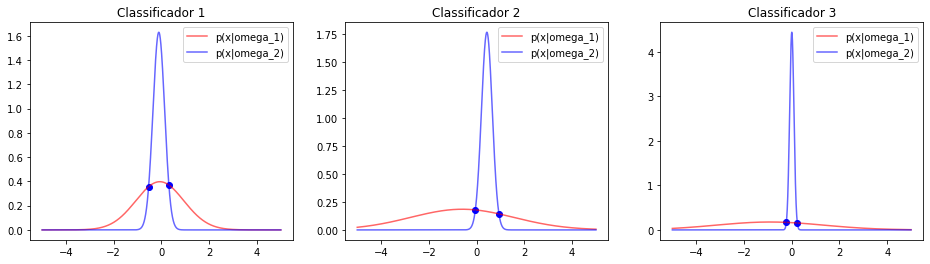

In [37]:
params = [params_1, params_2, params_3]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, ax in zip(range(len(params)), enumerate(fig.axes)):
    plot_probs(ax[1], params[i])
    ax[1].set_title('Classificador ' + str(i+1))
fig.subplots_adjust(hspace=0.4)

Entonces para todos los clasificadores tenemos que:

$$P(error) = \frac 12 \left[ \int_{-\infty}^{b_1} p(x|\omega_2) + \int_{b_1}^{b_2} p(x|\omega_1) + \int_{b_2}^{\infty} p(x|\omega_2) \right]$$

In [38]:
def get_error(params):
    mu_1, mu_2 = params[0][0], params[0][1] 
    var_1, var_2 = params[1][0], params[1][1]
    b1, b2 = get_boundaries(params)
    p_omega_2 = lambda x: norm.pdf(x,loc=mu_2,scale=np.sqrt(var_2))
    p_omega_1 = lambda x: norm.pdf(x,loc=mu_1,scale=np.sqrt(var_1))
    int_1, error = quad(p_omega_2, -np.inf, b1) 
    int_2, error = quad(p_omega_1, b1, b2)
    int_3, error = quad(p_omega_2, b2, np.inf)
    return 0.5*(int_1 + int_2 + int_3)

In [39]:
for i in range(len(params)):
    error = get_error(params[i])
    print('La probabilidad del error aproximada para el clasificador %d: %f' % (i+1, round(error, 5)))

La probabilidad del error aproximada para el clasificador 1: 0.205170
La probabilidad del error aproximada para el clasificador 2: 0.095110
La probabilidad del error aproximada para el clasificador 3: 0.042770


 <span style="color:red"> RESPONDA EL INCISO D AQUÍ </span>

 <span style="color:red"> RESPONDA EL INCISO E AQUÍ </span>